In [2]:
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn import model_selection
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from feature_engine.encoding import OneHotEncoder
from feature_engine import discretisation

from lightgbm import LGBMClassifier

pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

from pipeline.preprocess import *
from pipeline.utils import *
from pipeline.carregar_dados import *
from pipeline.criar_abt import *

from features.features_clientes import *
from features.features_quantidade import *
from features.features_valor import *
from features.features_tempo import *
from features.features_flags import *
from features.features_clientes_transacional import *

In [3]:
dados = carregar_dados()

df_clientes = dados['clientes']
df_inadimplencia = dados['inadimplencia']
df_transacoes = dados['transacoes']

clientes_prep = preprocessar_clientes(df_clientes)
inad_prep = preprocessar_inadimplencia(df_inadimplencia)
tran_prep = preprocessar_transacoes(df_transacoes)

inad_prep = inad_prep.dropna(subset=["atraso_90d"]).copy()

print("Clientes:", clientes_prep.shape)
print("Inadimplência:", inad_prep.shape)
print("Transações:", tran_prep.shape)

Clientes: (200, 10)
Inadimplência: (4790, 4)
Transações: (2000, 4)


In [4]:
abt = gerar_abt(clientes_prep, inad_prep, tran_prep, usar_M_1=True)

print("Shape M-1:", abt.shape)

Shape M-1: (4790, 99)


In [5]:
abt.head(10)

,id_cliente,mes_safra,data_referencia,atraso_90d,idade,renda_mensal,data_abertura_conta,mes_abertura_conta,estado_civil,tempo_emprego_anos,qtde_produtos,score_interno,limite_credito,idade2,log_renda,renda_por_limite,multi_produto_flag,vlr_trans_1m,vlr_trans_3m,vlr_trans_6m,vlr_trans_9m,vlr_trans_12m,vlr_trans_24m,vlr_trans_ever,vlr_trans_ult,vlr_trans_max,vlr_trans_min,comp_vlr_1m_vs_3m,delta_vlr_1m_vs_3m,comp_vlr_3m_vs_6m,delta_vlr_3m_vs_6m,comp_vlr_6m_vs_9m,delta_vlr_6m_vs_9m,comp_vlr_9m_vs_12m,delta_vlr_9m_vs_12m,comp_vlr_12m_vs_24m,delta_vlr_12m_vs_24m,comp_vlr_24m_vs_ever,delta_vlr_24m_vs_ever,qtde_trans_1m,qtde_trans_3m,qtde_trans_6m,qtde_trans_9m,qtde_trans_12m,qtde_trans_24m,qtde_trans_ever,pct_qtde_trans_1m,pct_qtde_trans_3m,pct_qtde_trans_6m,pct_qtde_trans_12m,pct_qtde_trans_24m,comp_qtde_1m_vs_3m,delta_qtde_1m_vs_3m,comp_qtde_3m_vs_6m,delta_qtde_3m_vs_6m,comp_qtde_6m_vs_9m,delta_qtde_6m_vs_9m,comp_qtde_9m_vs_12m,delta_qtde_9m_vs_12m,comp_qtde_12m_vs_24m,delta_qtde_12m_vs_24m,comp_qtde_24m_vs_ever,delta_qtde_24m_vs_ever,tempo_desde_primeira_1m,tempo_desde_ultima_1m,tempo_desde_primeira_3m,tempo_desde_ultima_3m,tempo_desde_primeira_6m,tempo_desde_ultima_6m,tempo_desde_primeira_9m,tempo_desde_ultima_9m,tempo_desde_primeira_12m,tempo_desde_ultima_12m,tempo_desde_primeira_24m,tempo_desde_ultima_24m,tempo_desde_primeira_ever,tempo_desde_ultima_ever,flag_nunca_transacionou,flag_transacao_1m,flag_transacao_3m,flag_transacao_6m,flag_transacao_9m,flag_transacao_12m,flag_transacao_24m,flag_transacao_ever,tempo_relacionamento_anos,tempo_relacionamento_meses,tempo_relacionamento_isna,flag_cliente_antigo,flag_cliente_antigo_isna,idade_relativa,limite_por_ano_conta,limite_por_ano_conta_isna,limite_por_mes_conta,limite_por_mes_conta_isna,produtos_por_ano_conta,produtos_por_ano_conta_isna,produtos_por_mes_conta,produtos_por_mes_conta_isna
0,C0001,2023-09,2023-09-30,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7139,20.5650,0,0.0,0,54.2861,13439.523893,0,1120.058352,0,2.917323,0,0.243132,0
1,C0001,2023-10,2023-10-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7960,21.5506,0,0.0,0,54.2040,12825.167038,0,1068.833350,0,2.783964,0,0.232012,0
2,C0001,2023-11,2023-11-30,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.8809,22.5690,0,0.0,0,54.1191,12246.265086,0,1020.603483,0,2.658302,0,0.221543,0
3,C0001,2023-12,2023-12-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.9630,23.5545,0,0.0,0,54.0370,11734.080489,0,977.902312,0,2.547122,0,0.212274,0
4,C0001,2024-01,2024-01-31,0.0,56,6530.0,2021-12-13,2021-12,solteiro,2.6,5,673.0,23034,3136,8.784315,0.283494,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,

In [6]:
abt.isna().mean().sort_values(ascending=False)

tempo_desde_ultima_1m          0.716075
tempo_desde_primeira_1m        0.716075
comp_vlr_1m_vs_3m              0.498330
comp_qtde_1m_vs_3m             0.497912
tempo_desde_ultima_3m          0.497912
tempo_desde_primeira_3m        0.497912
comp_qtde_3m_vs_6m             0.354071
tempo_desde_primeira_6m        0.354071
tempo_desde_ultima_6m          0.354071
comp_vlr_3m_vs_6m              0.354071
tempo_desde_ultima_9m          0.252610
tempo_desde_primeira_9m        0.252610
comp_qtde_6m_vs_9m             0.252610
comp_vlr_6m_vs_9m              0.252610
vlr_trans_ult                  0.243633
tempo_desde_primeira_12m       0.239875
comp_vlr_9m_vs_12m             0.239875
comp_qtde_9m_vs_12m            0.239875
tempo_desde_ultima_12m         0.239875
comp_vlr_24m_vs_ever           0.239040
comp_vlr_12m_vs_24m            0.239040
vlr_trans_min                  0.239040
vlr_trans_max                  0.239040
pct_qtde_trans_24m             0.239040
pct_qtde_trans_12m             0.239040


#### QUAL A INADIMPLÊNCIA TOTAL DA BASE DE DADOS? E AO LONGO DAS SAFRAS?

,atraso_90d,Qtd.
0,0.0,4306
1,1.0,484


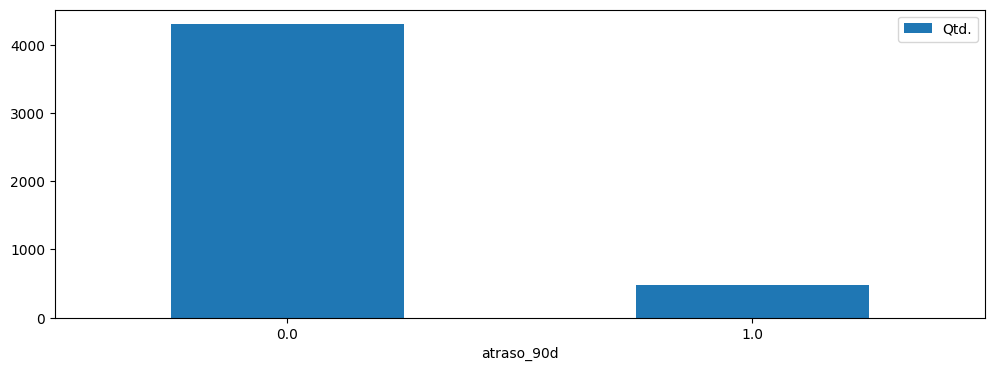

In [7]:
plot_categ(abt, 'atraso_90d')

,tx_mau,N
mes_safra,,
2023-09,0.090909,198
2023-10,0.100000,200
2023-11,0.125000,200
2023-12,0.095000,200
2024-01,0.075000,200
2024-02,0.115578,199
2024-03,0.085000,200
2024-04,0.095477,199
2024-05,0.125000,200


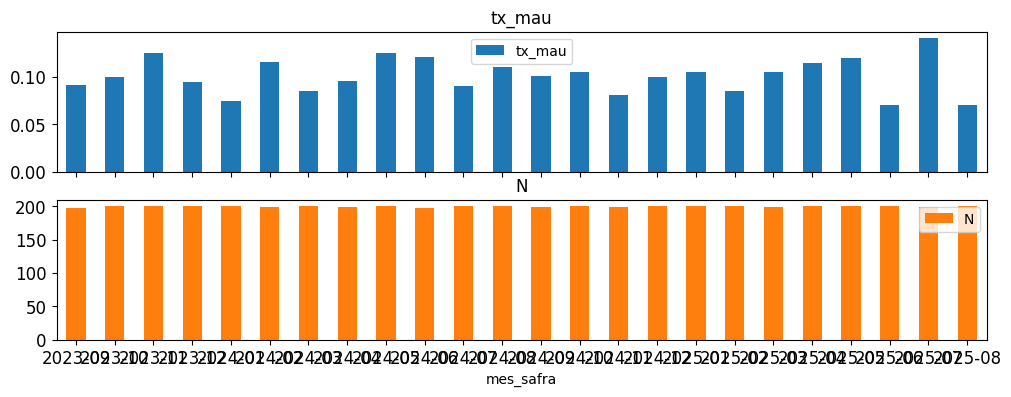

In [9]:
mau = 1
df2 =abt[['mes_safra', 'atraso_90d']].copy()
df2['mau'] = [1 if x == mau else 0 for x in df2['atraso_90d']]
aux = df2.groupby('mes_safra')["mau"].agg(["mean", 'count']
                                          )
aux = aux.rename(columns={'mean' : 'tx_mau', 'count' : 'N'})
aux.plot.bar(rot=0, subplots=True, figsize = (12,4), fontsize = 12)

aux

,Tx. inadimplência,Volumetria
mes_safra,,
2023-09,0.090909,198
2023-10,0.100000,200
2023-11,0.125000,200
2023-12,0.095000,200
2024-01,0.075000,200
2024-02,0.115578,199
2024-03,0.085000,200
2024-04,0.095477,199
2024-05,0.125000,200


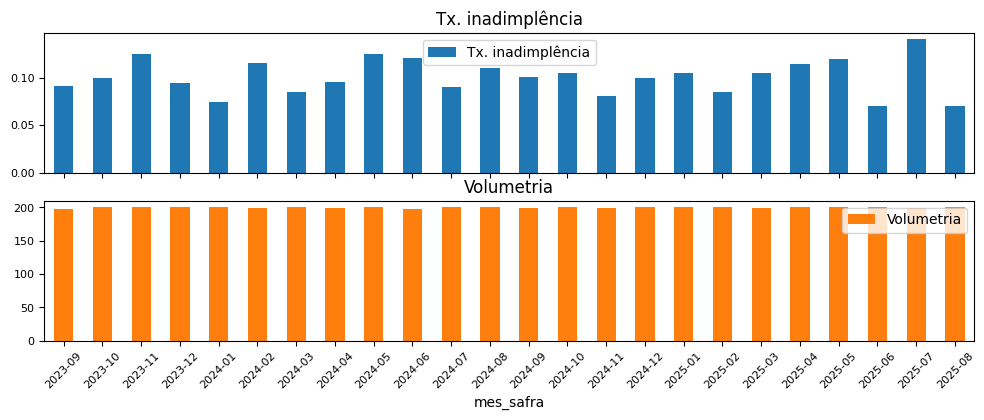

In [10]:
plot_txmau_categ(abt, column='mes_safra', column_mau='atraso_90d')


#### QUAL A INADIMPLÊNCIA POR CLIENTE?

In [12]:
mau = 1
df2 =abt[['id_cliente', 'atraso_90d']].copy()
df2['mau'] = [1 if x == mau else 0 for x in df2['atraso_90d']]
aux = df2.groupby('id_cliente')["mau"].agg(["mean", 'count']
                                          )
aux = aux.rename(columns={'mean' : 'tx_mau', 'count' : 'N'}).sort_values('tx_mau', ascending=False)
aux.head(50)

,tx_mau,N
id_cliente,,
C0030,0.291667,24
C0061,0.250000,24
C0163,0.250000,24
C0169,0.250000,24
C0031,0.208333,24
C0048,0.208333,24
C0006,0.208333,24
C0040,0.208333,24
C0185,0.208333,24


,Tx. inadimplência,Volumetria
estado_civil,,
casado,0.113150,981
divorciado,0.084650,886
nan,0.097222,792
solteiro,0.106646,1294
viuvo,0.099164,837


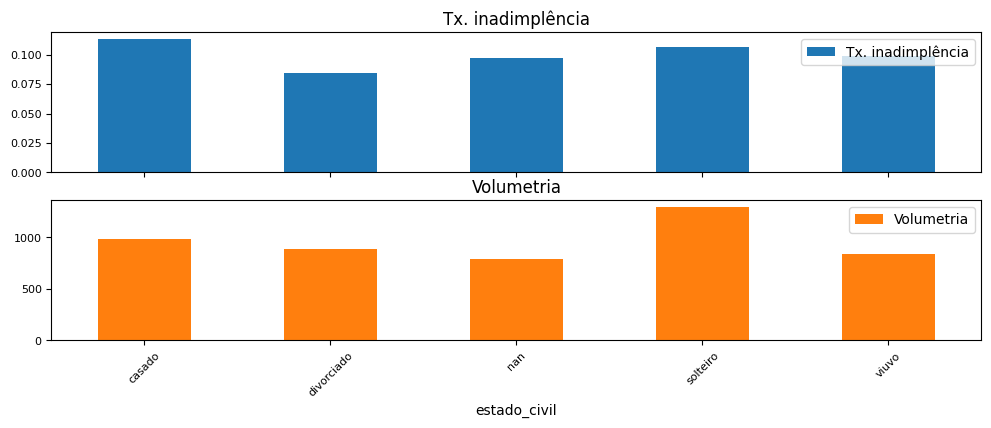

In [14]:
plot_txmau_categ(abt, column='estado_civil', column_mau='atraso_90d')

In [15]:
abt.columns

Index(['id_cliente', 'mes_safra', 'data_referencia', 'atraso_90d', 'idade',
       'renda_mensal', 'data_abertura_conta', 'mes_abertura_conta',
       'estado_civil', 'tempo_emprego_anos', 'qtde_produtos', 'score_interno',
       'limite_credito', 'idade2', 'log_renda', 'renda_por_limite',
       'multi_produto_flag', 'vlr_trans_1m', 'vlr_trans_3m', 'vlr_trans_6m',
       'vlr_trans_9m', 'vlr_trans_12m', 'vlr_trans_24m', 'vlr_trans_ever',
       'vlr_trans_ult', 'vlr_trans_max', 'vlr_trans_min', 'comp_vlr_1m_vs_3m',
       'delta_vlr_1m_vs_3m', 'comp_vlr_3m_vs_6m', 'delta_vlr_3m_vs_6m',
       'comp_vlr_6m_vs_9m', 'delta_vlr_6m_vs_9m', 'comp_vlr_9m_vs_12m',
       'delta_vlr_9m_vs_12m', 'comp_vlr_12m_vs_24m', 'delta_vlr_12m_vs_24m',
       'comp_vlr_24m_vs_ever', 'delta_vlr_24m_vs_ever', 'qtde_trans_1m',
       'qtde_trans_3m', 'qtde_trans_6m', 'qtde_trans_9m', 'qtde_trans_12m',
       'qtde_trans_24m', 'qtde_trans_ever', 'pct_qtde_trans_1m',
       'pct_qtde_trans_3m', 'pct_qtde_trans

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:416: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


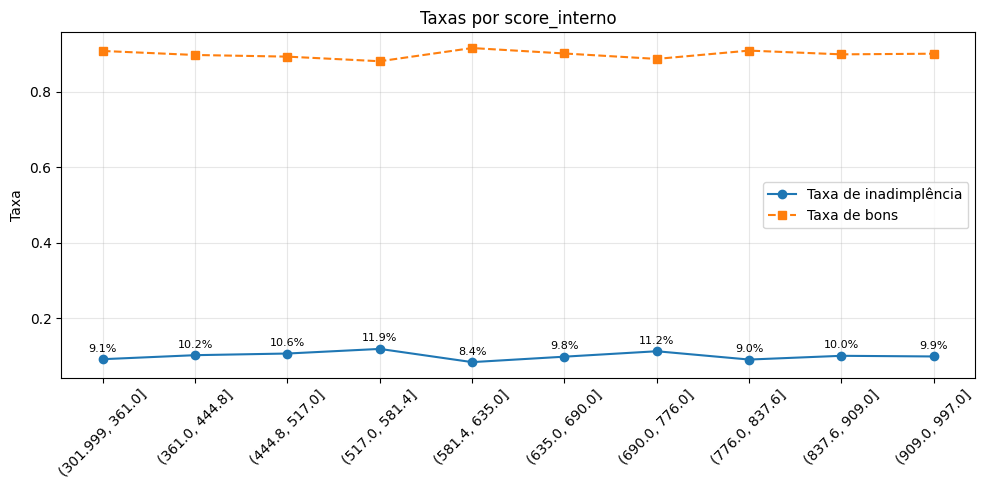

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(301.999, 361.0]",503,457,46,0.091451
1,"(361.0, 444.8]",431,387,44,0.102088
2,"(444.8, 517.0]",479,428,51,0.106472
3,"(517.0, 581.4]",455,401,54,0.118681
4,"(581.4, 635.0]",478,438,40,0.083682
5,"(635.0, 690.0]",479,432,47,0.098121
6,"(690.0, 776.0]",480,426,54,0.112500
7,"(776.0, 837.6]",431,392,39,0.090487
8,"(837.6, 909.0]",478,430,48,0.100418
9,"(909.0, 997.0]",456,411,45,0.098684


In [16]:
plot_inad_var(abt, "score_interno", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:416: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


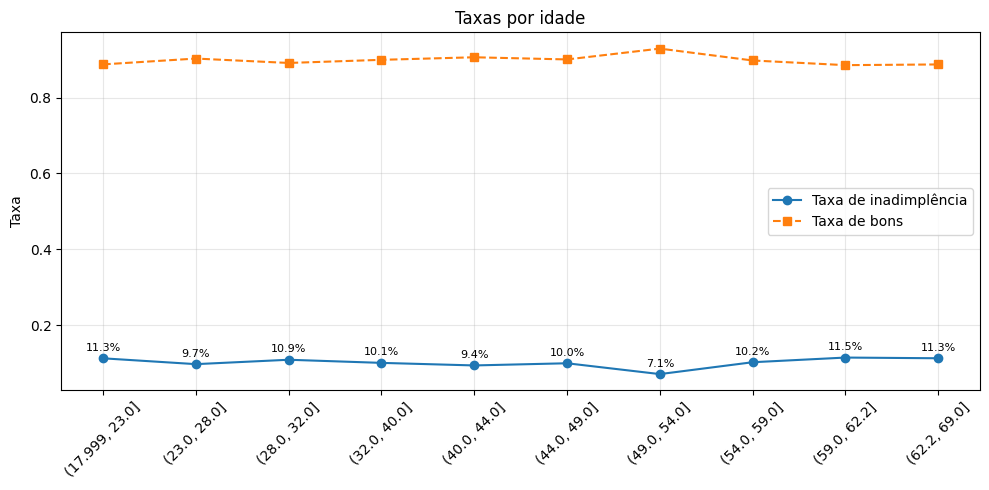

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(17.999, 23.0]",524,465,59,0.112595
1,"(23.0, 28.0]",504,455,49,0.097222
2,"(28.0, 32.0]",432,385,47,0.108796
3,"(32.0, 40.0]",527,474,53,0.100569
4,"(40.0, 44.0]",501,454,47,0.093812
5,"(44.0, 49.0]",432,389,43,0.099537
6,"(49.0, 54.0]",479,445,34,0.070981
7,"(54.0, 59.0]",528,474,54,0.102273
8,"(59.0, 62.2]",384,340,44,0.114583
9,"(62.2, 69.0]",479,425,54,0.112735


In [17]:
plot_inad_var(abt, "idade", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:416: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


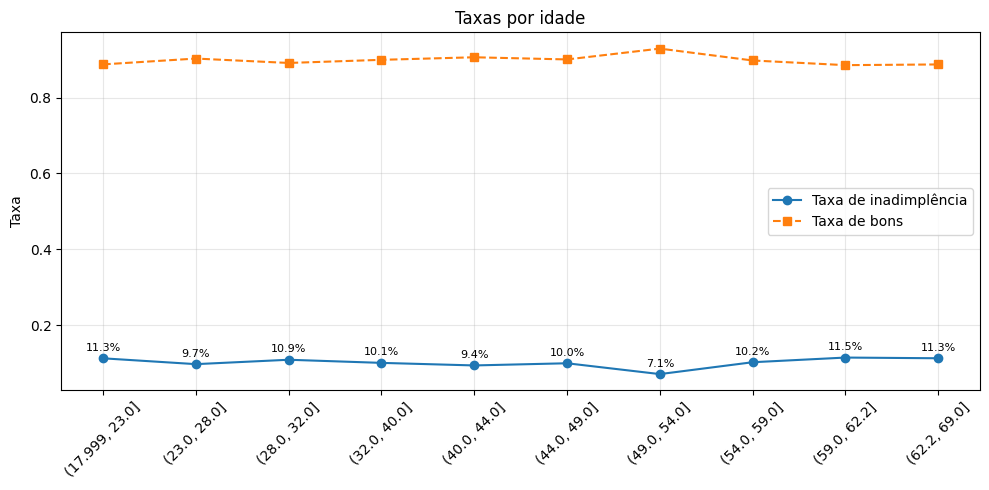

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(17.999, 23.0]",524,465,59,0.112595
1,"(23.0, 28.0]",504,455,49,0.097222
2,"(28.0, 32.0]",432,385,47,0.108796
3,"(32.0, 40.0]",527,474,53,0.100569
4,"(40.0, 44.0]",501,454,47,0.093812
5,"(44.0, 49.0]",432,389,43,0.099537
6,"(49.0, 54.0]",479,445,34,0.070981
7,"(54.0, 59.0]",528,474,54,0.102273
8,"(59.0, 62.2]",384,340,44,0.114583
9,"(62.2, 69.0]",479,425,54,0.112735


In [18]:
plot_inad_var(abt, "idade", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:416: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


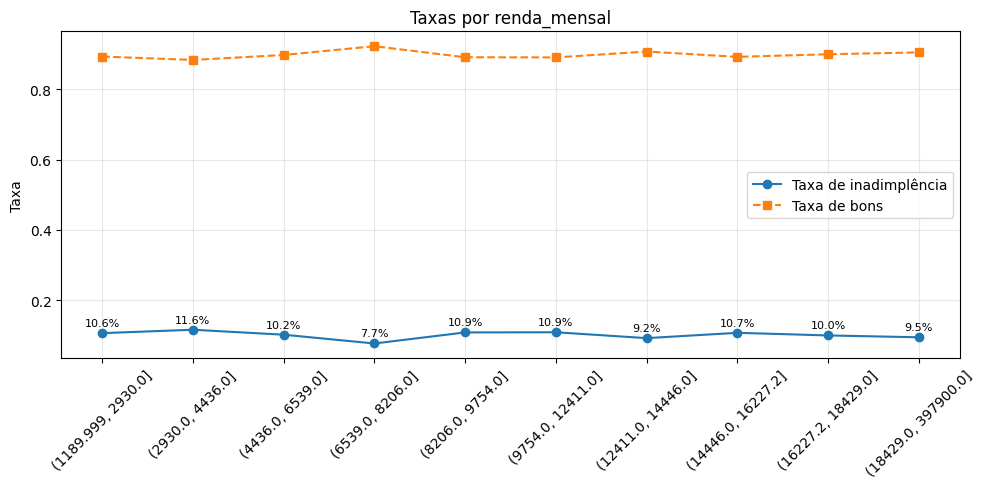

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(1189.999, 2930.0]",479,428,51,0.106472
1,"(2930.0, 4436.0]",456,403,53,0.116228
2,"(4436.0, 6539.0]",480,431,49,0.102083
3,"(6539.0, 8206.0]",454,419,35,0.077093
4,"(8206.0, 9754.0]",479,427,52,0.108559
5,"(9754.0, 12411.0]",477,425,52,0.109015
6,"(12411.0, 14446.0]",455,413,42,0.092308
7,"(14446.0, 16227.2]",456,407,49,0.107456
8,"(16227.2, 18429.0]",480,432,48,0.100000
9,"(18429.0, 397900.0]",454,411,43,0.094714


In [19]:
plot_inad_var(abt, "renda_mensal", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:416: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


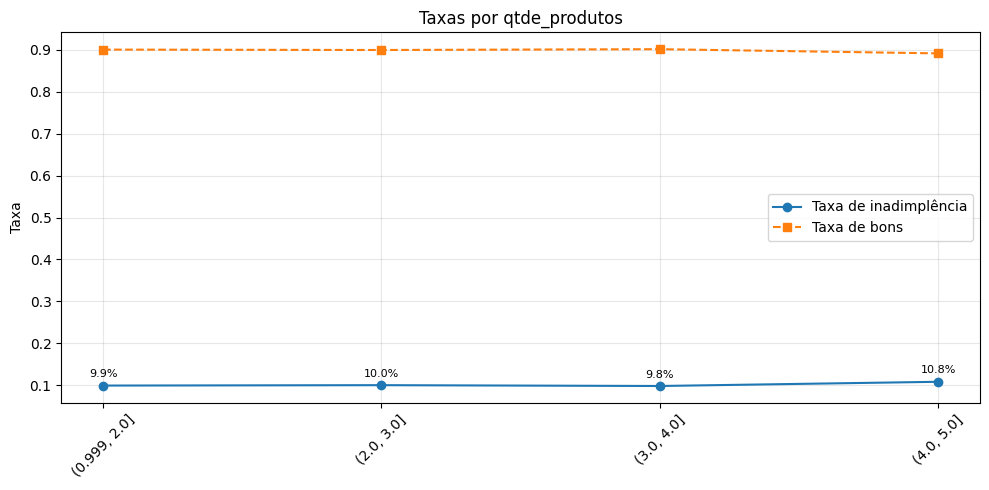

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(0.999, 2.0]",1987,1790,197,0.099144
1,"(2.0, 3.0]",1079,971,108,0.100093
2,"(3.0, 4.0]",744,671,73,0.098118
3,"(4.0, 5.0]",980,874,106,0.108163


In [20]:
plot_inad_var(abt, "qtde_produtos", target="atraso_90d", bins=10)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:416: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


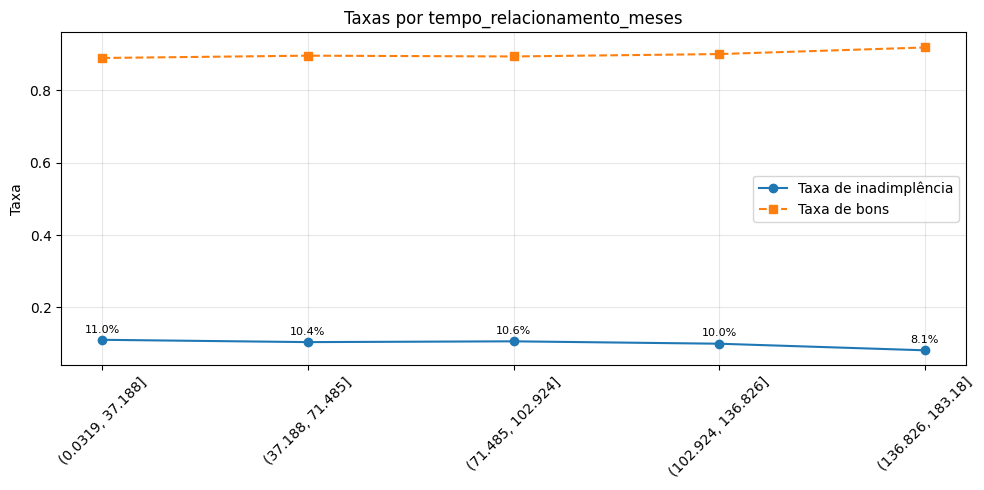

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(0.0319, 37.188]",924,822,102,0.110390
1,"(37.188, 71.485]",923,827,96,0.104009
2,"(71.485, 102.924]",923,825,98,0.106176
3,"(102.924, 136.826]",924,832,92,0.099567
4,"(136.826, 183.18]",922,847,75,0.081345


In [21]:
plot_inad_var(abt, "tempo_relacionamento_meses", target="atraso_90d", bins=5)

c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:416: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("faixa")


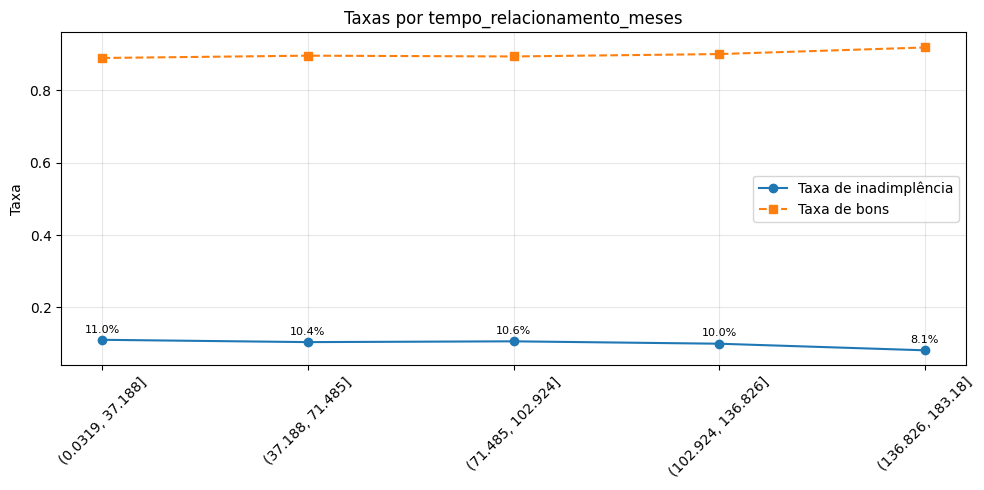

,faixa,n,n_bons,n_maus,taxa_inadimplencia
0,"(0.0319, 37.188]",924,822,102,0.110390
1,"(37.188, 71.485]",923,827,96,0.104009
2,"(71.485, 102.924]",923,825,98,0.106176
3,"(102.924, 136.826]",924,832,92,0.099567
4,"(136.826, 183.18]",922,847,75,0.081345


In [22]:
plot_inad_var(abt, "tempo_relacionamento_meses", target="atraso_90d", bins=5)

In [23]:
cols_drop = ['id_cliente', 'data_referencia', 'data_abertura_conta', 'mes_abertura_conta','mes_safra']

remover = remover_vars(abt, iv_threshold=0.000001,corr_threshold=0.8, cols_drop=cols_drop)

In [24]:
len(remover['removidas_corr'])

40

In [25]:
len(remover['final'])

31

In [26]:
col_retirar = cols_drop + ['atraso_90d']
X_TODAS = abt.drop(columns=col_retirar)

X_train_TODAS, X_test_TODAS = model_selection.train_test_split(X_TODAS,
                                                 test_size=0.2,
                                                 random_state=42
)

In [27]:
X = abt[remover['final']]
y = abt['atraso_90d']

In [28]:
(X.shape, len(y))

((4790, 31), 4790)

In [29]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.2,
                                                                    random_state=42)

### 1. DECISION TREE CLASSIFIER

#### TREINO COM COLUNAS PRÉ-SELECIONADAS A PARTIR DA FUNÇÃO REMOVER_VARS()

In [30]:
arvore = tree.DecisionTreeClassifier(random_state=42,
                                     max_depth=5,
                                     min_samples_split=10)

arvore.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


[Text(0.5, 0.8333333333333334, 'qtde_trans_1m <= 3.5\ngini = 0.183\nsamples = 3832\nvalue = [3442, 390]\nclass = 0.0'),
 Text(0.25, 0.5, 'idade_relativa <= 59.68\ngini = 0.181\nsamples = 3812\nvalue = [3429, 383]\nclass = 0.0'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'tempo_emprego_anos <= 4.15\ngini = 0.455\nsamples = 20\nvalue = [13, 7]\nclass = 0.0'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

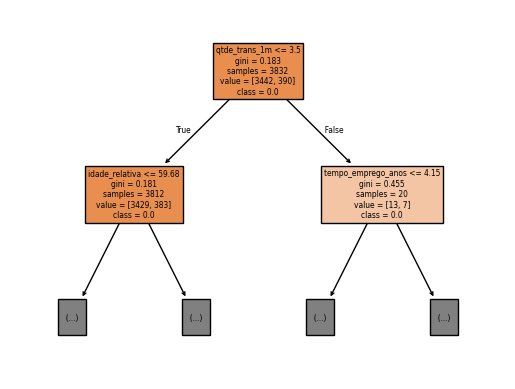

In [31]:
tree.plot_tree(arvore,
               feature_names=X_train.columns,
               max_depth=1,
               filled=True,
               class_names=[str(i) for i in arvore.classes_])

In [32]:
feature_importances= (pd.Series(arvore.feature_importances_,
                                index=X_train.columns)
                           .sort_values(ascending=False)
                           .reset_index()
                           )
feature_importances
feature_importances['acum.'] = feature_importances[0].cumsum()

# %%
best_features = feature_importances[feature_importances['acum.'] < 0.96]

In [33]:
best_features

,index,0,acum.
0,tempo_desde_primeira_9m,0.201862,0.201862
1,idade_relativa,0.177159,0.379021
2,tempo_emprego_anos,0.132826,0.511846
3,delta_vlr_6m_vs_9m,0.107924,0.619771
4,qtde_trans_1m,0.070748,0.690519
5,delta_vlr_3m_vs_6m,0.062805,0.753323
6,tempo_desde_primeira_6m,0.062415,0.815738
7,vlr_trans_ult,0.053728,0.869466
8,limite_credito,0.052718,0.922184


In [34]:
y_train_predict = arvore.predict(X_train[best_features])
y_train_proba = arvore.predict_proba(X_train[best_features])[:, 1]

acc_train = metrics.accuracy_score(y_train, y_train_predict)
auc_train = metrics.roc_auc_score(y_train, y_train_proba)
roc_train = metrics.roc_curve(y_train, y_train_proba)

print("Acurácia treino: ", acc_train)
print("AUC treino: ", auc_train)


y_test_predict = arvore.predict(X_test[best_features])
y_test_proba = arvore.predict_proba(X_test[best_features])[:, 1]

acc_test = metrics.accuracy_score(y_test, y_test_predict)
auc_test = metrics.roc_auc_score(y_test, y_test_proba)
roc_test = metrics.roc_curve(y_test,y_test_proba)
                             
                             
print("Acurácia teste: ", acc_test)
print("AUC teste: ", auc_test)

Acurácia treino:  0.8982254697286013
AUC treino:  0.5
Acurácia teste:  0.9018789144050104
AUC teste:  0.5


c:\Users\mooliveira\Desktop\Estudos\Cases\Ailos - Case técnico\pipeline\utils.py:376: RuntimeWarning: invalid value encountered in scalar divide
  precision_1 = np.sum((actual == 1) & (preds == 1)) / np.sum(preds == 1)


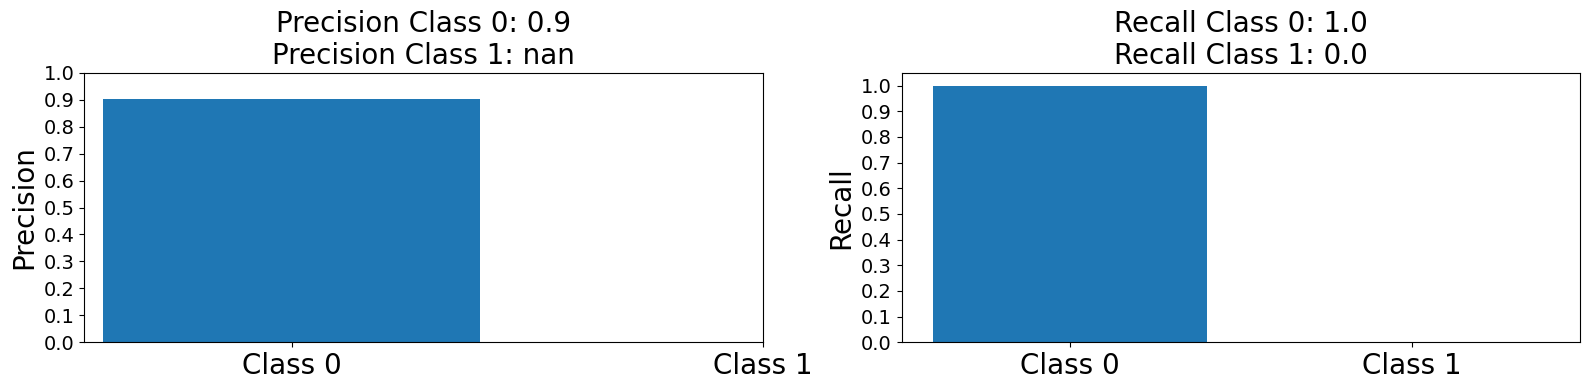

In [35]:
get_precisions_recalls(y_test,y_test_predict)

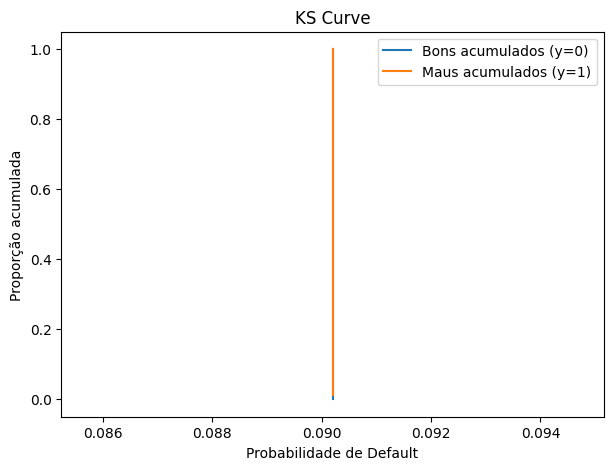

(np.float64(0.1511524822695035), np.float64(0.09019754006708908))

In [36]:
plotar_ks(y_test,y_test_proba)

### 2. CATBOOST


In [37]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import numpy as np

#### 2.1 TREINO COM TODAS AS COLUNAS QUE NÃO SEJAM ID E DATAS

In [38]:
cat_features = [col for col in X_train_TODAS.columns if X_train_TODAS[col].dtype.name in ["object", "category"]]

cat_features

['estado_civil']

In [39]:
# ===============================
# 1. Identificar variáveis categóricas
# ===============================
cat_features = [col for col in X_train_TODAS.columns if X_train_TODAS[col].dtype.name in ["object", "category"]]

print("Variáveis categóricas:", cat_features)

# ===============================
# 2. Definir modelo base
# ===============================
weight_minority_class = np.sum(y_train == 0) / np.sum(y_train == 1)

catboost = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    class_weights=[1, weight_minority_class],   # penaliza mais a classe 1 (inadimplente), ajuste se precisar
    logging_level='Info'
)

# ===============================
# 3. Espaço de hiperparâmetros
# ===============================
param_dist = {
    "depth": [4, 6, 8, 10],
    "learning_rate": np.linspace(0.01, 0.2, 5),
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "iterations": [200, 400, 600, 800],
    "border_count": [32, 64, 128]
}

# ===============================
# 4. RandomizedSearchCV
# ===============================
random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_dist,
    n_iter=20,           
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# CatBoost precisa de Pool para saber quais colunas são categóricas
train_pool = Pool(X_train_TODAS, y_train, cat_features=cat_features)

# Ajustar busca
random_search.fit(X_train_TODAS, y_train, cat_features=cat_features)




Variáveis categóricas: ['estado_civil']
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

flag_transacao_1m, bin=1 score 5.48799383
vlr_trans_min, bin=24 score 5.961141266
flag_transacao_12m, bin=1 score 7.840849636
tempo_desde_primeira_1m, bin=7 score 7.195416026
qtde_trans_12m, bin=3 score 8.397972517
tempo_desde_primeira_ever, bin=12 score 9.873459718
tempo_desde_ultima_6m, bin=5 score 11.00029201
tempo_relacionamento_meses, bin=18 score 13.27429136
delta_vlr_6m_vs_9m, bin=18 score 14.51319753
comp_vlr_9m_vs_12m, bin=14 score 17.71029711
0:	total: 410ms	remaining: 1m 21s

delta_qtde_9m_vs_12m, bin=5 score 4.028909337
qtde_trans_1m, bin=3 score 6.308631314
vlr_trans_ever, bin=26 score 8.164823071
idade2, bin=25 score 7.2837953
delta_vlr_12m_vs_24m, bin=3 score 8.985399905
comp_vlr_9m_vs_12m, bin=21 score 9.312753524
tempo_desde_primeira_24m

,estimator,<catboost.cor...0029F58F168A0>
,param_distributions,"{'border_count': [32, 64, ...], 'depth': [4, 6, ...], 'iterations': [200, 400, ...], 'l2_leaf_reg': [1, 3, ...], ...}"
,n_iter,20
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [40]:
# ===============================
# 5. Avaliar no teste
# ===============================
best_model = random_search.best_estimator_
y_proba_cat = best_model.predict_proba(X_test_TODAS)[:, 1]
y_pred_cat = best_model.predict(X_test_TODAS)

print("Melhores parâmetros:", random_search.best_params_)
print("AUC:", roc_auc_score(y_test, y_proba_cat))
print("F1 :", f1_score(y_test, y_pred_cat))
print("Precisão:", precision_score(y_test, y_pred_cat))
print("Recall:", recall_score(y_test, y_pred_cat))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_cat))

Melhores parâmetros: {'learning_rate': np.float64(0.15250000000000002), 'l2_leaf_reg': 9, 'iterations': 200, 'depth': 10, 'border_count': 32}
AUC: 0.47761524822695034
F1 : 0.10810810810810811
Precisão: 0.10989010989010989
Recall: 0.10638297872340426
Matriz de confusão:
 [[783  81]
 [ 84  10]]


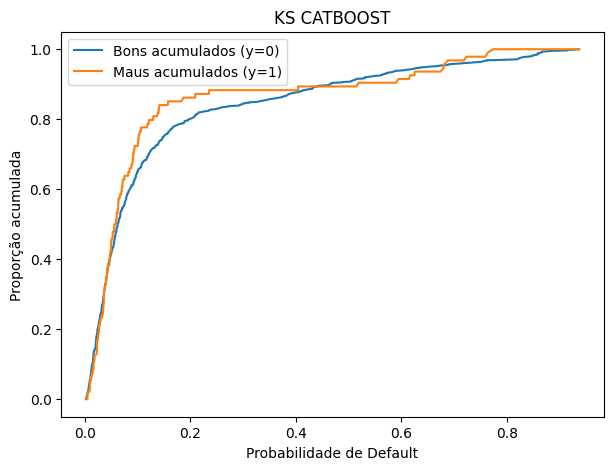

(np.float64(0.1134013002364066), np.float64(0.10691179864014161))

In [41]:
plotar_ks(y_test,y_proba_cat, titulo='KS CATBOOST')

In [42]:
import pandas as pd
feat_imp = pd.DataFrame({
    "feature": X_train_TODAS.columns,
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False)
print(feat_imp.head(20))


                       feature  importance
3           tempo_emprego_anos    5.321718
2                 estado_civil    4.551538
5                score_interno    4.043917
9             renda_por_limite    3.678852
6               limite_credito    3.628089
80  tempo_relacionamento_meses    3.170156
91      produtos_por_mes_conta    3.063652
61     tempo_desde_primeira_6m    3.036176
87        limite_por_mes_conta    2.862441
20               vlr_trans_min    2.815893
1                 renda_mensal    2.633218
18               vlr_trans_ult    2.531955
84              idade_relativa    2.457830
7                       idade2    2.388622
19               vlr_trans_max    2.361514
4                qtde_produtos    2.217042
63     tempo_desde_primeira_9m    1.941403
79   tempo_relacionamento_anos    1.932033
0                        idade    1.877179
59     tempo_desde_primeira_3m    1.849577


#### 2.2 TREINO COM COLUNAS PRÉ-SELECIONADAS A PARTIR DA FUNÇÃO REMOVER_VARS()

In [43]:
# ===============================
# 1. Identificar variáveis categóricas
# ===============================
cat_features = [col for col in X_train.columns if X_train[col].dtype.name in ["object", "category"]]

print("Variáveis categóricas:", cat_features)

# ===============================
# 2. Definir modelo base
# ===============================
weight_minority_class = np.sum(y_train == 0) / np.sum(y_train == 1)

catboost = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    class_weights=[1, weight_minority_class],   # penaliza mais a classe 1 (inadimplente), ajuste se precisar
    logging_level="Silent"
)

# ===============================
# 3. Espaço de hiperparâmetros
# ===============================
param_dist = {
    "depth": [4, 6, 8, 10],
    "learning_rate": np.linspace(0.01, 0.2, 10),
    "l2_leaf_reg": [1, 3, 5, 7, 9],
    "iterations": [200, 400, 600, 800],
    "border_count": [32, 64, 128]
}

# ===============================
# 4. RandomizedSearchCV
# ===============================
random_search2 = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_dist,
    n_iter=20,              # nº de combinações testadas (ajuste se quiser mais)
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# CatBoost precisa de Pool para saber quais colunas são categóricas
train_pool = Pool(X_train, y_train, cat_features=cat_features)

# Ajustar busca
random_search2.fit(X_train, y_train, cat_features=cat_features)




Variáveis categóricas: []
Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,<catboost.cor...0029F589F87A0>
,param_distributions,"{'border_count': [32, 64, ...], 'depth': [4, 6, ...], 'iterations': [200, 400, ...], 'l2_leaf_reg': [1, 3, ...], ...}"
,n_iter,20
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [245]:
# ===============================
# 5. Avaliar no teste
# ===============================
best_model2 = random_search2.best_estimator_
y_proba_cat2 = best_model2.predict_proba(X_test)[:, 1]
y_pred_cat2 = best_model2.predict(X_test)

print("Melhores parâmetros:", random_search.best_params_)
print("AUC:", roc_auc_score(y_test, y_proba_cat2))
print("F1 :", f1_score(y_test, y_pred_cat2))
print("Precisão:", precision_score(y_test, y_pred_cat2))
print("Recall:", recall_score(y_test, y_pred_cat2))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_cat2))

Melhores parâmetros: {'learning_rate': np.float64(0.15250000000000002), 'l2_leaf_reg': 9, 'iterations': 200, 'depth': 10, 'border_count': 32}
AUC: 0.4547072005516155
F1 : 0.06451612903225806
Precisão: 0.06521739130434782
Recall: 0.06382978723404255
Matriz de confusão:
 [[778  86]
 [ 88   6]]


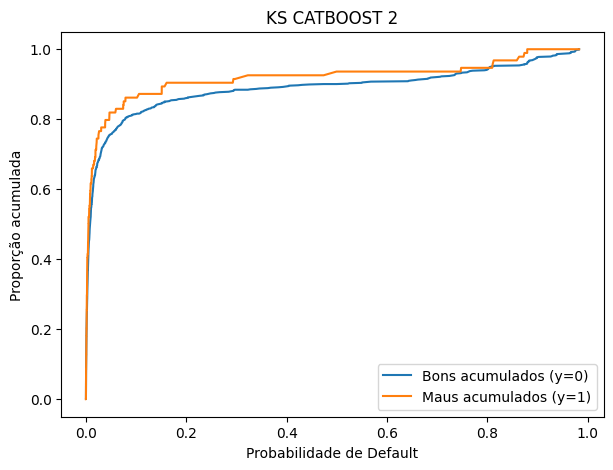

(np.float64(0.11143124507486207), np.float64(0.0025873454849642606))

In [248]:
plotar_ks(y_test,y_proba_cat2, titulo='KS CATBOOST 2')

## COMO ARRUMAR?

#### Proposta 1 - UPWEIGHT THE MINORITY CLASS

In [249]:
weight_minority_class = np.sum(y_train == 0) / np.sum(y_train == 1)

weight_minority_class

np.float64(8.825641025641026)

In [250]:
arvore2 = tree.DecisionTreeClassifier(class_weight={0:1, 1:weight_minority_class}, random_state=42)
arvore2.fit(X_train, y_train)
preds = arvore2.predict(X_test)

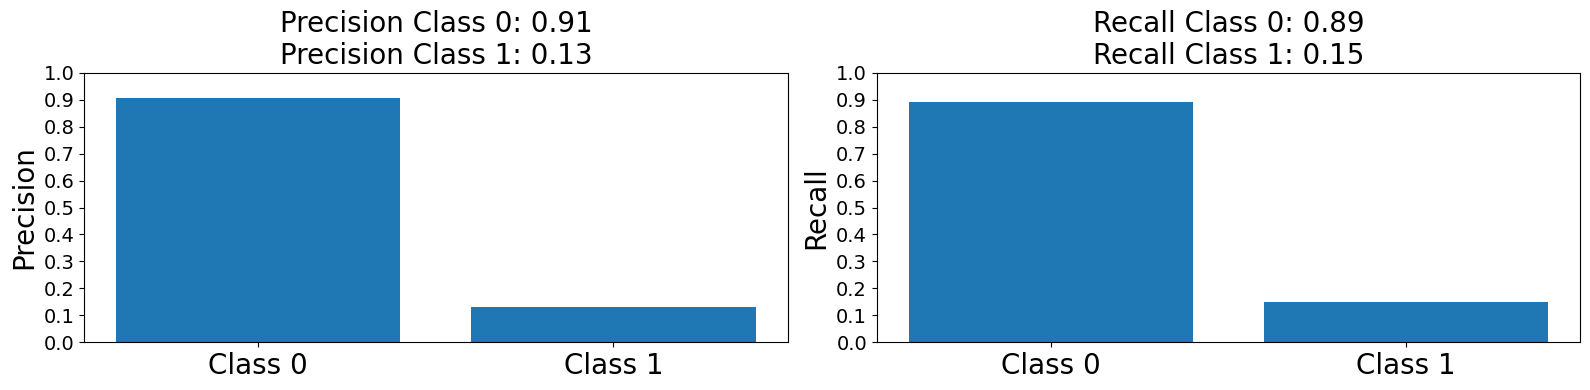

In [251]:
get_precisions_recalls(y_test, preds)

In [252]:
y_train_predict2 = arvore2.predict(X_train)
y_train_proba2 = arvore2.predict_proba(X_train)[:, 1]

acc_train2 = metrics.accuracy_score(y_train, y_train_predict2)
auc_train2 = metrics.roc_auc_score(y_train, y_train_proba2)
roc_train2 = metrics.roc_curve(y_train, y_train_proba2)

print("Acurácia treino: ", acc_train2)
print("AUC treino: ", auc_train2)

y_test_predict2 = arvore2.predict(X_test)
y_test_proba2 = arvore2.predict_proba(X_test)[:, 1]

acc_test2 = metrics.accuracy_score(y_test, y_test_predict2)
auc_test2 = metrics.roc_auc_score(y_test, y_test_proba2)
roc_test2 = metrics.roc_curve(y_test,y_test_proba2)
                             
                             
print("Acurácia teste: ", acc_test2)
print("AUC teste: ", auc_test2)

Acurácia treino:  0.9924321503131524
AUC treino:  0.9904948673251985
Acurácia teste:  0.8194154488517745
AUC teste:  0.5205316686367218


#### Proposta 2 - Oversample Minority Class

In [253]:
#get indices of each class
indices_0 = np.where(y_train == 0)[0]
indices_1 = np.where(y_train == 1)[0]
indices = np.concatenate([indices_0, indices_1])

#get weights for each class
weights = np.empty(indices_0.shape[0] + indices_1.shape[0])
weights[:indices_0.shape[0]] = 1
weights[indices_0.shape[0]:] = weight_minority_class
weights = weights/np.sum(weights)

#sample new indices
sampled_indices = np.random.choice(indices, indices.shape[0], p=weights)

In [254]:
# construir datasets oversampled
X_train_oversampled = X_train.iloc[sampled_indices]
labels_train_oversampled = y_train.iloc[sampled_indices]


In [255]:
print('Fraction of positive labels in oversampled data:', str(round(100*np.mean(labels_train_oversampled),3)) + '%')

Fraction of positive labels in oversampled data: 49.87%


In [256]:
arvore3 = tree.DecisionTreeClassifier(random_state=42,
                                  max_depth=5,
                                  min_samples_split=10)

arvore3.fit(X_train_oversampled, labels_train_oversampled)
preds = arvore3.predict(X_test)

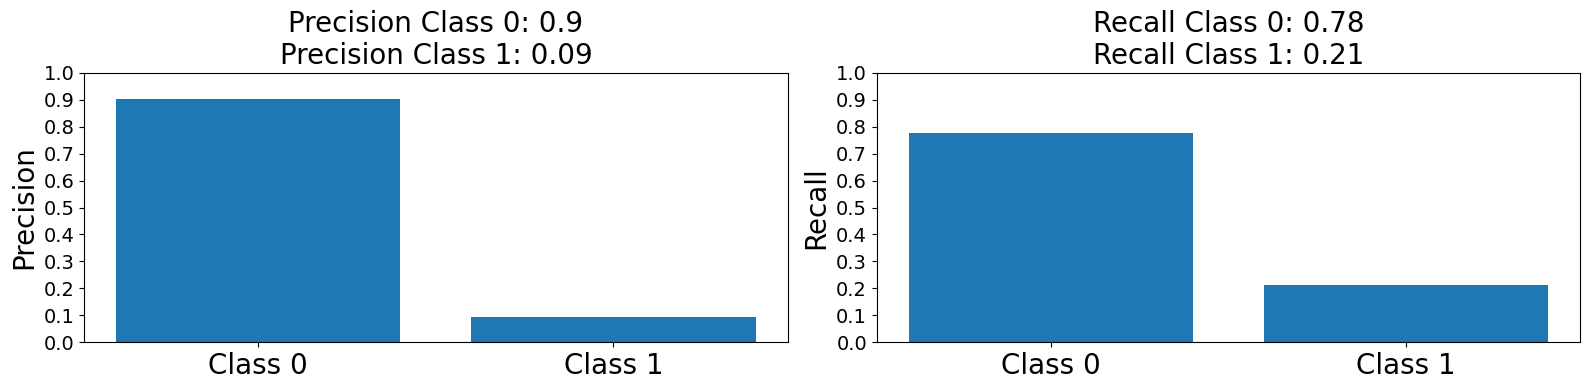

In [257]:
get_precisions_recalls(y_test, preds)

In [ ]:
y_train_predict3 = arvore3.predict(X_train_oversampled)
y_train_proba3 = arvore3.predict_proba(X_train_oversampled)[:, 1]

acc_train3 = metrics.accuracy_score(labels_train_oversampled, y_train_predict3)
auc_train3 = metrics.roc_auc_score(labels_train_oversampled, y_train_proba3)
roc_train3 = metrics.roc_curve(labels_train_oversampled, y_train_proba3)

print("Acurácia treino: ", acc_train3)
print("AUC treino: ", auc_train3)

y_test_predict3 = arvore3.predict(X_test)
y_test_proba3 = arvore3.predict_proba(X_test)[:, 1]

acc_test3 = metrics.accuracy_score(y_test, y_test_predict3)
auc_test3 = metrics.roc_auc_score(y_test, y_test_proba3)
roc_test3 = metrics.roc_curve(y_test,y_test_proba3)
                           
print("Acurácia teste: ", acc_test3)
print("AUC teste: ", auc_test3)



Acurácia treino:  0.6075156576200418
AUC treino:  0.6661334377181778
Acurácia teste:  0.7223382045929019
AUC teste:  0.5037184791174153


0.2127659574468085